#Usage of Autoencoders to create synthetic datasets
This notebook will show you how to create and implement Autoencoders and VAE systems respectively. The dataset that will be using is the Fashion MNIST Data set comprised of 28x28 images of 10 different articles of clothing. More details below:

#Libraries, Dataset Installation, etc.:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Define a transform to convert the images to tensors (and optionally normalize)
transform = transforms.Compose([
    transforms.ToTensor(),                  # Converts image to [0, 1] range
    transforms.Lambda(lambda x: x.view(-1))   # Flatten the image
])

# Download and load the training data
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Download and load the test data
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Wrap the datasets with DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

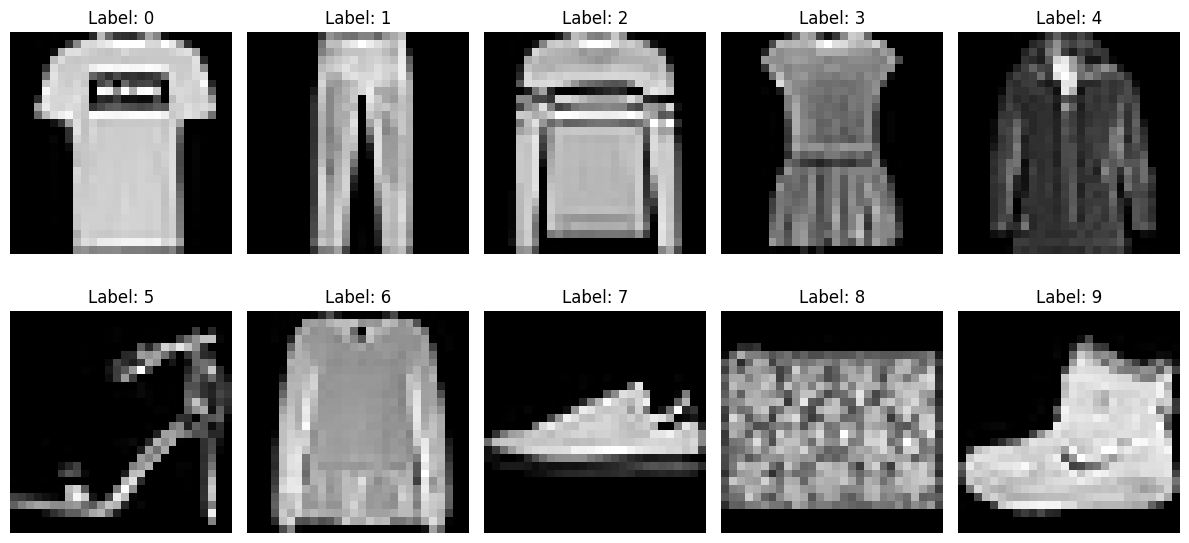

In [ ]:
# Dictionary to store the first image for each unique label
found = {}

# Iterate through the dataset to find one image per label
for img, label in train_dataset:
    if label not in found:
        found[label] = img
    if len(found) == 10:  # FashionMNIST has 10 classes
        break

# Plot one image for each unique label after reshaping to 28x28
plt.figure(figsize=(12, 6))
for label, img in found.items():
    plt.subplot(2, 5, label + 1)
    plt.imshow(img.view(28, 28), cmap='gray')  # Reshape the flattened image back to 28x28
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

**Labels being**:  
0: T-shirt/top  
1: Trouser  
2: Pullover  
3: Dress  
4: Coat  
5: Sandal  
6: Shirt  
7: Sneaker  
8: Bag  
9: Ankle boot  

#Part 1: Simple Autoencoders

##Instructions:
We will create a very simple autoencoder. Autoencoders follow two main steps:<br>
1. **Encoding**: Reducing dimensionality into a latent space
2. **Decoding**: Increasing dimensionality from the latent space to the original matrix dimensions  

Try to create the individual modules yourself. Some helpful functions are listed below:  

*  `nn.Sequential()`: Another way of organizing steps in architecture. Just list
the steps in order of how you want the model to run. Helpful when you are trying to segment larger custom architectures for readability. For example a previous CNN that we have made...


```
class CNN(nn.Module):
  def __init__(self):
    #3 color channels so start with 3
        super(CNN, self).__init__()
        
        #Defining unique layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    #Pooling layer stays constant
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    # Pooling layer of 2 causes the images w/h to decrease by half each time, final size before condensing is therefore 4x4
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with 20% dropout rate, retains the 10 classes at the end
        self.fc1 = nn.Linear(32*4*4,10)

  def forward(self, x):
  
        #Assembling architecture from layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.softmax(self.conv3(x)))
        x = self.dropout(x)  # Apply dropout
        x = torch.flatten(x,1)  # Hint: Flatten before passing to fully connected layer
        x = self.fc1(x)
        return x
```
Can be equivalently written as:
```
model = nn.Sequential(
    #Just list the steps from begining to end
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Dropout(p=0.2),
    nn.Flatten(),
    nn.Linear(32*4*4, 10)
)
```

Where you can further organize into smaller sequential chunks if you want. Note that you don't have to define the entire model in one sequential statement and should still use a forward function when defining a class. Also the output of the previous line automatically becomes the input of the next line within `nn.Sequential`.
*  `nn.Linear(input_dim,out_dim)`: Used for compressing or expanding dimensions
*  `nn.Relu()` or `nn.Sigmoid()`: Activation functions




##Try it yourself:
Create a model:  
1. Encodes an image from the original size to 128 dimensions
2. Encodes again from 128 to 64 dimensions (Reaching the latent space)
3. Decodes from the latent space to 128 dimensions
4. Decodes from 128 dimensions back to the original size

In [ ]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: compress the image (28x28) to a 64-dimensional representation
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        # Decoder: reconstruct the image from the 64-dimensional representation
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Ensure output is between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Training Loop:

In [ ]:
# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for data, _ in train_loader:
        optimizer.zero_grad()         # Zero the parameter gradients
        output = model(data)            # Forward pass
        loss = criterion(output, data)  # Compute reconstruction loss
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights

        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/10, Loss: 0.4742
Epoch 2/10, Loss: 0.3604
Epoch 3/10, Loss: 0.3304
Epoch 4/10, Loss: 0.3180
Epoch 5/10, Loss: 0.3132
Epoch 6/10, Loss: 0.3102
Epoch 7/10, Loss: 0.3077
Epoch 8/10, Loss: 0.3052
Epoch 9/10, Loss: 0.3029
Epoch 10/10, Loss: 0.3007


Testing model...

In [ ]:
import torch
import torch.nn.functional as F
import math
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt

# Evaluation on the test dataset
model.eval()  # Set model to evaluation mode

total_mse = 0.0
total_mae = 0.0
total_ssim = 0.0
num_samples = 0

with torch.no_grad():
    for data, _ in test_loader:
        output = model(data)  # Forward pass
        mse = F.mse_loss(output, data, reduction='mean').item()
        mae = F.l1_loss(output, data, reduction='mean').item()
        total_mse += mse
        total_mae += mae

        batch_size = data.size(0)
        num_samples += batch_size
        # Compute SSIM for each image in the batch
        for i in range(batch_size):
            # Reshape to 28x28 (images are flattened)
            input_img = data[i].view(28, 28).cpu().detach().numpy()
            output_img = output[i].view(28, 28).cpu().detach().numpy()
            ssim_val = compare_ssim(input_img, output_img, data_range=1.0)
            total_ssim += ssim_val

avg_mse = total_mse / len(test_dataset)
avg_mae = total_mae / len(test_dataset)
avg_ssim = total_ssim / num_samples
avg_psnr = 10 * math.log10(1 / avg_mse) if avg_mse != 0 else float('inf')

print(f"Test MSE: {avg_mse:.4f}")
print(f"Test MAE: {avg_mae:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")
print(f"Test SSIM: {avg_ssim:.4f}")

Test MSE: 0.0002
Test MAE: 0.0006
Test PSNR: 38.17 dB
Test SSIM: 0.6105


**Valuation metrics:**
*  MSE(Mean Standard Deviation): Should be closer to 0
*  MAE(Mean Absolute Error): Should be closer to 0
*  PSNR(Peak Signal-to-Noise Ratio): Higher is better
*  SSIM(Structural Similarity Index): 1 means perfect similarity, 0 means no similarity

Generating synthetic images using the decoder

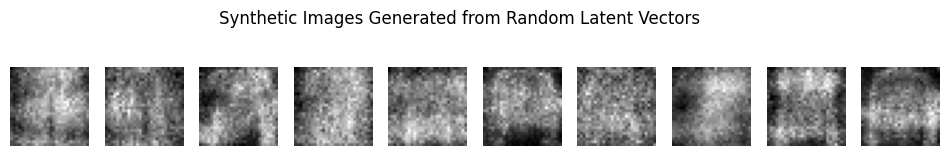

In [ ]:
# Sample random latent vectors from a standard normal distribution
num_samples = 10
latent_dim = 64  # Must match the latent dimension from your encoder
random_latents = torch.randn(num_samples, latent_dim)

# Generate synthetic images by passing the latent vectors through the decoder
with torch.no_grad():
    synthetic_images = model.decoder(random_latents)
synthetic_images = synthetic_images.view(-1, 28, 28)  # Reshape to 28x28 images

# Plot the synthetic images
plt.figure(figsize=(12, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(synthetic_images[i].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle('Synthetic Images Generated from Random Latent Vectors')
plt.show()

Image quality is pretty bad visually in diversity, but some shapes are still recognizable. Let's see if we can make this better.

#Part 2: VAE systems

We are going to be implementing a VAE system. The major difference between this and an autoencoder is that this takes into account the mean and variance of the data within the latent space. The math is provided for sampling and integrating mean and variance respectively through the `reparameterize` function, taking the mean and variance as parameters.

##Try it yourself:
1. Modify the encoder portion before the latent space (from the autoencoder we made before) to create the separate layers required for mean and variance respectively
2. Modify the `forward` function to include these new layers. (Hint: reparameterize is used before the decoder is used)

In [ ]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28*28,128),
        nn.ReLU(True)
    )

    self.mu = nn.Linear(128,64)
    self.logvar = nn.Linear(128,64)

    self.decoder = nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(True),
        nn.Linear(128, 28 * 28),
        nn.Sigmoid()
    )

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    x = self.encoder(x)
    mu = self.mu(x)
    logvar = self.logvar(x)

    x = self.reparameterize(mu,logvar)
    final = self.decoder(x)
    return final, mu, logvar

Training loop(now includes KL divergence for regulation of latent space):

In [ ]:
# Initialize the model, loss function, and optimizer
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def criterion(recon, data, mu, logvar):
    # Compute reconstruction loss (Binary Cross-Entropy)
    BCE = nn.functional.binary_cross_entropy(recon, data, reduction='mean')

    # Compute KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for data, _ in train_loader:
        optimizer.zero_grad()         # Zero the parameter gradients
        output = model(data)            # Forward pass
        recon, mu, logvar = output
        loss = criterion(recon, data, mu, logvar)   # Compute reconstruction loss + KL divergence
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights

        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/10, Loss: 5.7699
Epoch 2/10, Loss: 1.1897
Epoch 3/10, Loss: 0.7860
Epoch 4/10, Loss: 0.6440
Epoch 5/10, Loss: 0.5686
Epoch 6/10, Loss: 0.5305
Epoch 7/10, Loss: 0.5129
Epoch 8/10, Loss: 0.5031
Epoch 9/10, Loss: 0.4982
Epoch 10/10, Loss: 0.4957


Testing model...

In [ ]:
import torch
import torch.nn.functional as F
import math
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt

# Evaluation on the test dataset
model.eval()  # Set model to evaluation mode

total_mse = 0.0
total_mae = 0.0
total_ssim = 0.0
num_samples = 0

with torch.no_grad():
    for data, _ in test_loader:
        recon, _, _ = model(data)  # Extract reconstruction from model output
        mse = F.mse_loss(recon, data, reduction='mean').item()
        mae = F.l1_loss(recon, data, reduction='mean').item()
        total_mse += mse
        total_mae += mae

        batch_size = data.size(0)
        num_samples += batch_size
        # Compute SSIM for each image in the batch
        for i in range(batch_size):
            # Reshape to 28x28 (images are flattened)
            input_img = data[i].view(28, 28).cpu().detach().numpy()
            output_img = recon[i].view(28, 28).cpu().detach().numpy()
            ssim_val = compare_ssim(input_img, output_img, data_range=1.0)
            total_ssim += ssim_val

avg_mse = total_mse / len(test_dataset)
avg_mae = total_mae / len(test_dataset)
avg_ssim = total_ssim / num_samples
avg_psnr = 10 * math.log10(1 / avg_mse) if avg_mse != 0 else float('inf')

print(f"Test MSE: {avg_mse:.4f}")
print(f"Test MAE: {avg_mae:.4f}")
print(f"Test PSNR: {avg_psnr:.2f} dB")
print(f"Test SSIM: {avg_ssim:.4f}")

Test MSE: 0.0007
Test MAE: 0.0018
Test PSNR: 31.63 dB
Test SSIM: 0.1683


Generating synthetic images using the decoder


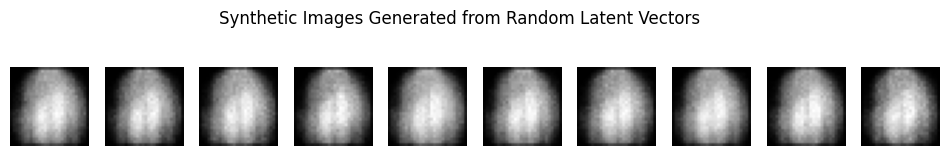

In [ ]:
# Sample random latent vectors from a standard normal distribution
num_samples = 10
latent_dim = 64  # Must match the latent dimension from your encoder
random_latents = torch.randn(num_samples, latent_dim)

# Generate synthetic images by passing the latent vectors through the decoder
with torch.no_grad():
    synthetic_images = model.decoder(random_latents)
synthetic_images = synthetic_images.view(-1, 28, 28)  # Reshape to 28x28 images

# Plot the synthetic images
plt.figure(figsize=(12, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(synthetic_images[i].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle('Synthetic Images Generated from Random Latent Vectors')
plt.show()

By using VAE we were able to create better synthetic data compared to before(a lot less noise). However the quality of the images is still much to be desired. Some parameters that could be tinkered with include:
*  Latent space dimensionality (higher = better, but could very easily lead to overfitting)
*  Changing the weight of the KL divergence term(Also known as β-VAE)
*  Learning rate
*  Batch sizes
*  Number of Epochs
*  Different Optimizers